In [1]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lvgp_pytorch.models import LVGPR
from lvgp_pytorch.optim import fit_model_scipy, noise_tune

'''
from lvgp_pytorch.utils.variables import NumericalVariable,CategoricalVariable
from lvgp_pytorch.utils.input_space import InputSpace

from typing import Dict
from copy import deepcopy
'''

%matplotlib inline
plt.rcParams['figure.dpi']=150
# plt.rc("font", size=12)
# plt.rcParams['font.family']='serif'

def set_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
## How to use GPU?
MP_data = pd.read_csv('D:/PSED/MP_data.csv', index_col=0)
OQMD_data = pd.read_csv('D:/PSED/OQMD_xtalsys.csv', index_col=0)

In [2]:
MP_data.columns.values
OQMD_data.columns.values

array(['Co', 'Ni', 'W', 'Al', 'Cr', 'Fe', 'Ti', 'Cu', 'structure',
       'volume', 'bandgap', 'natoms', 'ntypes', 'energy',
       'crystal_structure', 'crystal_system'], dtype=object)

In [3]:
all_data = pd.concat([OQMD_data.drop(columns=['bandgap', 'structure', 'crystal_structure']), 
                      MP_data.drop(columns=['bandgap', 'structure'])], ignore_index=True).drop_duplicates()
all_data_original = all_data
all_data = all_data[all_data['energy']<1]
# Use space group instead of crystal system here
# all_data = pd.concat([OQMD_data.drop(columns=['bandgap', 'crystal_system', 'crystal_structure']), 
#                       MP_data.drop(columns=['bandgap', 'crystal_system'])], ignore_index=True).drop_duplicates()

all_y = all_data['energy']
all_x = all_data.drop(columns='energy')
qual_index = [11]  # [10]
quant_index =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # [0, 1, 2, 3, 4, 5, 6, 8, 9, 10]
num_levels_per_var = [len(pd.unique(all_x.iloc[:,i])) for i in qual_index]

# Convert categoricl variable to number labels
all_x['crystal_system'] = all_x['crystal_system'].astype('category').cat.codes
# all_x['structure'] = all_x['structure'].astype('category').cat.codes

set_seed(42)
from sklearn.model_selection import train_test_split
# CV requires .fit, use train/test instead
train_and_test = train_test_split(all_x, all_y, test_size=0.3)
train_x, test_x, train_y, test_y = [torch.from_numpy(array.values) for array in train_and_test]

In [4]:
all_x.columns.values

array(['Co', 'Ni', 'W', 'Al', 'Cr', 'Fe', 'Ti', 'Cu', 'volume', 'natoms',
       'ntypes', 'crystal_system'], dtype=object)

In [5]:
all_data.to_csv("D:/PSED/alloy_data.csv")

## Define and fit the model

In [6]:
model = LVGPR(
    train_x=train_x,
    train_y=train_y,
    qual_index=qual_index,
    quant_index=quant_index,
    num_levels_per_var=num_levels_per_var,
    quant_correlation_class="RBFKernel",
    fix_noise=False
).double()  # .cuda()

reslist,nll_inc = fit_model_scipy(
    model,
    num_restarts=9, # number of starting points
    n_jobs=9
)

# set model to eval model; default is in train model
_ = model.eval()

# get RRMSE
with torch.no_grad():
    # set return_std = False if standard deviation is not needed 
    test_mean,test_std = model.predict(test_x, return_std=True)

rrmse = torch.sqrt(((test_y - test_mean) ** 2).mean() / ((test_y - test_y.mean()) ** 2).mean())
r2 = 1 - rrmse ** 2
print('RRMSE : %5.3f'%rrmse.item())
print(r'R^2 : %5.3f' %r2.item())

RRMSE : 0.454
R^2 : 0.794


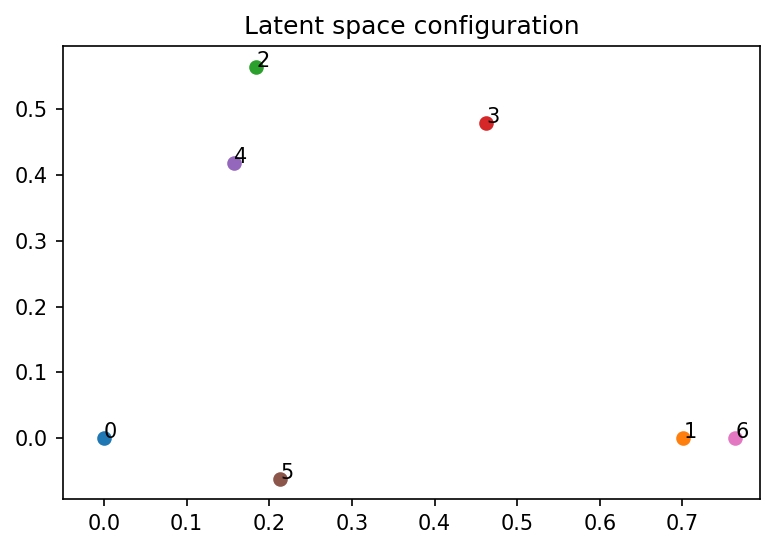

In [7]:
import matplotlib.pyplot as plt

latents = model.lv_mapping_layers[0].latents.detach().numpy()
# plt.scatter(latents[:,0], latents[:,1])
fig, ax = plt.subplots()
for i in range(latents.shape[0]):
    ax.scatter(latents[i,0], latents[i,1])
    ax.annotate(str(i), (latents[i,0], latents[i,1]))
ax.set_xbound(lower=-0.05, upper=None)
plt.title('Latent space configuration')
plt.show()

In [8]:
'''
model1 = LVGPR(
    train_x=train_x,
    train_y=train_y,
    qual_index=qual_index,
    quant_index=quant_index,
    num_levels_per_var=num_levels_per_var,
    quant_correlation_class="RBFKernel",
    fix_noise=False
).double()

# optimize noise successively
nll_inc_tuned,opt_history = noise_tune(
    model1, 
    num_restarts = 9, # number of restarts in the initial iteration
    n_jobs=9
)

_ = model1.eval()
with torch.no_grad():
    # set return_std = False if standard deviation is not needed 
    test_mean,test_std = model1.predict(test_x, return_std=True)

rrmse = torch.sqrt(((test_y - test_mean) ** 2).mean() / ((test_y - test_y.mean()) ** 2).mean())
r2 = 1 - rrmse**2
print('RRMSE : %5.3f'%rrmse.item())
print(r'R^2 : %5.3f' %r2.item())
'''

'\nmodel1 = LVGPR(\n    train_x=train_x,\n    train_y=train_y,\n    qual_index=qual_index,\n    quant_index=quant_index,\n    num_levels_per_var=num_levels_per_var,\n    quant_correlation_class="RBFKernel",\n    fix_noise=False\n).double()\n\n# optimize noise successively\nnll_inc_tuned,opt_history = noise_tune(\n    model1, \n    num_restarts = 9, # number of restarts in the initial iteration\n    n_jobs=9\n)\n\n_ = model1.eval()\nwith torch.no_grad():\n    # set return_std = False if standard deviation is not needed \n    test_mean,test_std = model1.predict(test_x, return_std=True)\n\nrrmse = torch.sqrt(((test_y - test_mean) ** 2).mean() / ((test_y - test_y.mean()) ** 2).mean())\nr2 = 1 - rrmse**2\nprint(\'RRMSE : %5.3f\'%rrmse.item())\nprint(r\'R^2 : %5.3f\' %r2.item())\n'

## Plot latent variable configuration

In [9]:
'''
import matplotlib.pyplot as plt

latents = model1.lv_mapping_layers[0].latents.detach().numpy()
# plt.scatter(latents[:,0], latents[:,1])
fig, ax = plt.subplots()
for i in range(latents.shape[0]):
    ax.scatter(latents[i,0], latents[i,1])
    ax.annotate(str(i), (latents[i,0]+0.01, latents[i,1]), fontsize=12)
plt.title('Latent space configuration')
plt.show()
'''

"\nimport matplotlib.pyplot as plt\n\nlatents = model1.lv_mapping_layers[0].latents.detach().numpy()\n# plt.scatter(latents[:,0], latents[:,1])\nfig, ax = plt.subplots()\nfor i in range(latents.shape[0]):\n    ax.scatter(latents[i,0], latents[i,1])\n    ax.annotate(str(i), (latents[i,0]+0.01, latents[i,1]), fontsize=12)\nplt.title('Latent space configuration')\nplt.show()\n"

## Find which structure a label correpsonds to

In [10]:
# all_data['crystal_system'][np.argwhere(all_x['crystal_system'].values == 4)[0]]
# all_data['structure'][np.argwhere(all_x['structure'].values == 5)[0]]

## Misc visualizations

KeyError: 'Pb'

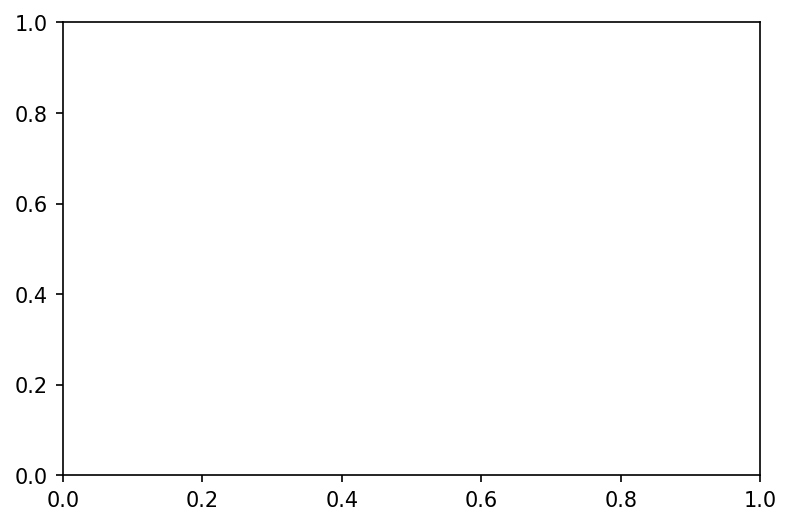

In [11]:
fig, ax = plt.subplots()
elems = ['Co', 'Al', 'W', 'Ni', 'Pb', 'Te']
train_freq = [np.count_nonzero(train_and_test[0][el]) for el in elems]
test_freq = [np.count_nonzero(train_and_test[1][el]) for el in elems]
width = 0.35
x = np.arange(len(elems))

ax.bar(x-width/2, train_freq, width, label='train')
ax.bar(x+width/2, test_freq, width, label='test')
ax.set_xticks(x, elems)
ax.legend()
ax.set_title('Element distribution')
# ax.bar(elems, compounds)
plt.show()

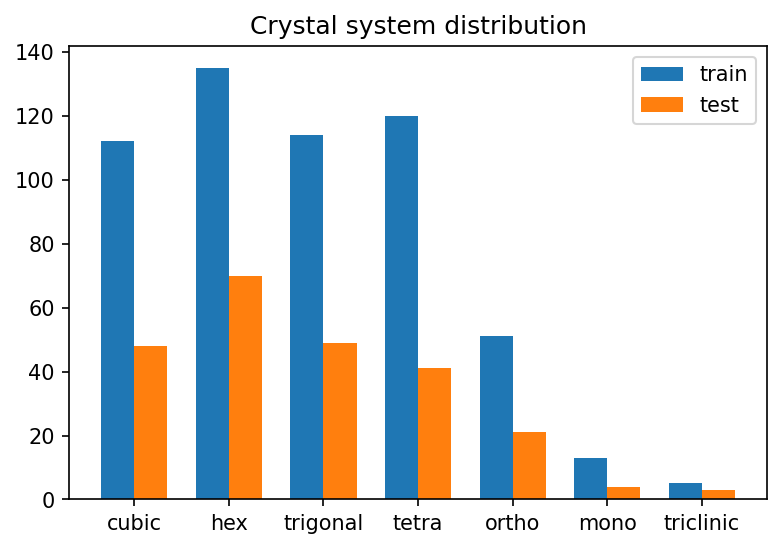

In [ ]:
fig, ax = plt.subplots()
crystal_sys = ['cubic', 'hex', 'trigonal', 'tetra', 'ortho', 'mono', 'triclinic']
train_freq = [np.count_nonzero(train_and_test[0]['crystal_system'] == i) for i in [0, 1, 6, 4, 3, 2, 5]]
test_freq = [np.count_nonzero(train_and_test[1]['crystal_system'] == i) for i in [0, 1, 6, 4, 3, 2, 5]]
width = 0.35
x = np.arange(len(crystal_sys))

ax.bar(x-width/2, train_freq, width, label='train')
ax.bar(x+width/2, test_freq, width, label='test')
ax.set_xticks(x, crystal_sys)
ax.legend()
ax.set_title('Crystal system distribution')
# ax.bar(elems, compounds)
plt.show()

In [ ]:
np.count_nonzero(train_and_test[1]["crystal_system"] == 1)

70

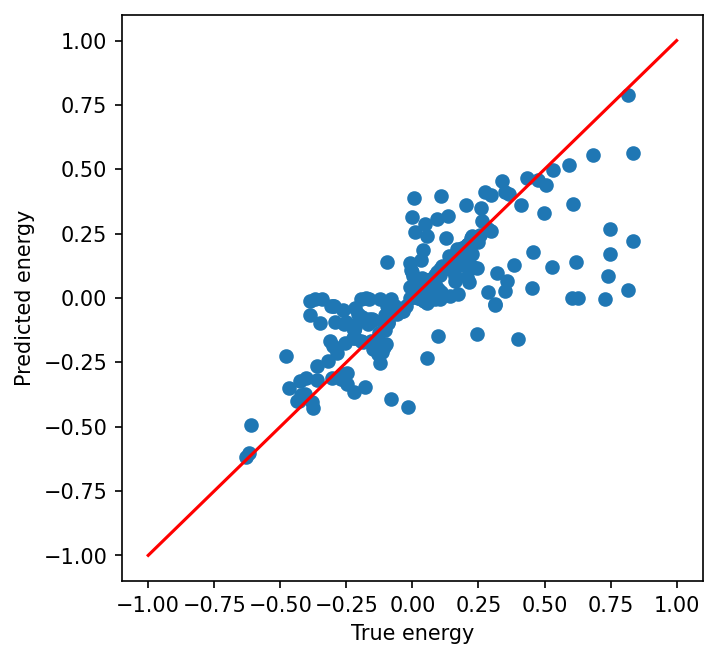

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(test_y, test_mean)
plt.plot(np.linspace(-1,1), np.linspace(-1,1), color='red')
plt.xlabel("True energy")
plt.ylabel("Predicted energy")
plt.show()

In [ ]:
torch.argmax(test_mean)

tensor(13)

In [ ]:
# train_and_test[1][np.abs(test_mean)<0.01]
small_idx = np.abs(test_mean)<0.01
train_and_test[1][small_idx.numpy()]

,Al,Co,Ni,Ti,W,Te,Pb,volume,natoms,ntypes,crystal_system
594,0.0,1.0,0.0,0,5.0,0.0,0.0,396.586000,24,2,1
824,0.0,5.0,0.0,0,0.0,6.0,0.0,210.761189,11,2,6
234,2.0,0.0,1.0,0,0.0,0.0,0.0,264.040000,6,2,0
263,3.0,0.0,1.0,0,0.0,0.0,0.0,464.147000,32,2,4
872,0.0,0.0,0.0,0,1.0,2.0,0.0,357.022761,9,2,1
55,24.0,5.0,0.0,0,0.0,0.0,0.0,461.447000,29,2,0
339,0.0,0.0,1.0,0,0.0,0.0,0.0,21.506700,2,1,1
850,0.0,0.0,3.0,0,0.0,2.0,0.0,174.892666,10,2,2
816,0.0,19.0,0.0,0,0.0,34.0,0.0,1165.061524,53,2,5
29,14.0,1.0,0.0,0,0.0,0.0,0.0,478.421000,30,2,4


In [ ]:
test_predictions = np.concatenate([train_and_test[1], test_mean.numpy()[:,np.newaxis]], axis=1)

In [ ]:
latents

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 6.99365622e-01,  0.00000000e+00],
       [ 1.88970949e-01,  5.68246051e-01],
       [ 4.65156798e-01,  4.81095176e-01],
       [ 1.55904012e-01,  4.18654059e-01],
       [ 2.11844494e-01, -5.91209028e-02],
       [ 7.62990729e-01, -2.21362160e-04]])

In [ ]:
np.unique(all_data.crystal_system.values)

array(['cubic', 'hexagonal', 'missing', 'monoclinic', 'orthorhombic',
       'tetragonal', 'triclinic', 'trigonal'], dtype=object)